# Anomaly detection

In [1]:
# Remove sklearn annoying warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
from detector import *

In [3]:
# loading cars
cars = pd.read_csv("CQA_Premium.csv")\
          [['model_length_mm', 'model_width_mm']]\
          .rename(columns={
            'model_length_mm': 'length',
            'model_width_mm': 'width'
          })
cars.is_copy = False

cars.loc[:, 'class'] = "car"
print('cars shape:\t{0}'.format(cars.shape))

cars shape:	(70847, 3)


Loading *body measurements*. Our database is not correct so we do not have a proper  *length* measurement. So this is more to show the program works.

In [4]:
# loading pedestrians
body = pd.read_csv("body.csv", sep=';')\
       [['shoulder.girth', 'chest.girth']]\
       .rename(columns={
           'shoulder.girth': 'width',
           'chest.girth': 'length'
       })
        
# converting cm to mm
body['width'] = body['width'].map(lambda x: 10 * float(x.replace(',', '.')))
body['length'] = body['length'].map(lambda x: 10 * float(x.replace(',', '.')))

body.is_copy = False
body.loc[:, 'class'] = "human"
print('body shape:\t{0}'.format(body.shape))

body shape:	(507, 3)


We found 2 short databases with motorbikes measurements, so we load them separatly, and concatenate them.

In [5]:
moto1 = pd.read_csv("moto.csv", sep=';')\
        [['Overall length (mm)', 'Overall width (mm)']]\
        .rename(columns={
            'Overall length (mm)': 'length',
            'Overall width (mm)': 'width'
        }).dropna(0, 'any')

# converting to float
moto1['width'] = moto1['width'].map(lambda x: float(str(x).replace(' ', '')))
moto1['length'] = moto1['length'].map(lambda x: float(str(x).replace(' ', '')))

moto2 = pd.read_csv("moto2.csv", sep=';')\
        [['LARGHEZZA (mm)', 'LUNGHEZZA (mm)']]\
        .rename(columns={
            'LARGHEZZA (mm)': 'width',
            'LUNGHEZZA (mm)': 'length'
        })
        
moto2['width'] = moto2['width'].map(lambda x: float(str(x).replace(' ', '')))
moto2['length'] = moto2['length'].map(lambda x: float(str(x).replace(' ', '')))

# we remove a point at length ~20k that messes up the plot
# during concatenation
moto = moto1.append(moto2[moto2['length'] < 10000])

moto.is_copy = False
moto.loc[:, 'class'] = 'moto'
print('moto shape:\t{0}'.format(moto.shape))

moto shape:	(201, 3)


In [6]:
# same here we remove some cars with really odd size
detector = Detector(cars[cars['width'] < 3000].append(body).append(moto))

loaded 5646 rows (0.21 s)


Here we append random odd points, which might not be the best thing to do. We plan on thinking about how an intruder could want to alter data.

using seed: 81437270


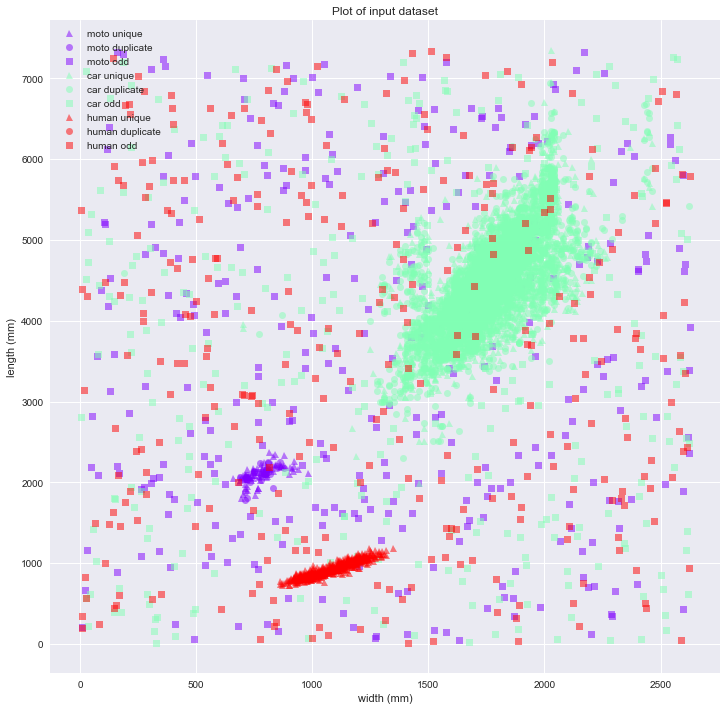

In [7]:
minx, maxx = 0, max(detector.df['width']) + 1
miny, maxy = 0, max(detector.df['length']) + 1
n = 1000
tmp = []
for k in range(n):
    tmp.append([rd.choice(list(set(detector.df['class']))),
                rd.randint(miny, maxy),
                rd.randint(minx, maxx)])
detector.append_odd_points(tmp)
detector.format()
detector.plot()

In the next cells, SVM is missing or commented due to computation time savings. We are still working on the code base. We have not fully explored our possibilities.

Also, classifiers parameters are for now sort of random, the goal here was to make sure the code works. Work in progress.

In [8]:
from sklearn import svm
from sklearn import ensemble
from sklearn import neural_network
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


classifiers = [
    neural_network.MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
    ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=36, learning_rate=1),
    # svm.SVC(kernel='linear'),
    ensemble.RandomForestClassifier()
]

titles = (
    'perceptron   ',
    'adaboost     ',
    # 'svm          ',
    'random forest'
)

results = {}
for clf, title in zip(classifiers, titles):
    results[title] = confusion_ratios(detector.classify(clf)[0])

for _ in range(len(titles[0])):
    print(' ', end='')
print('\tTPR\tFPR\tTNR\tFNR\tPPV\tF1')
for title in results.keys():
    print("{0}\t".format(title), end='')
    for x in results[title]:
        print('{0}\t'.format(round(x, 4)), end='')
    print()

             	TPR	FPR	TNR	FNR	PPV	F1
perceptron   	0.6694	0.0088	0.9912	0.3306	0.928	0.7778	
adaboost     	0.9376	0.0091	0.9909	0.0624	0.9455	0.9415	
random forest	0.9252	0.0042	0.9958	0.0748	0.9737	0.9488	


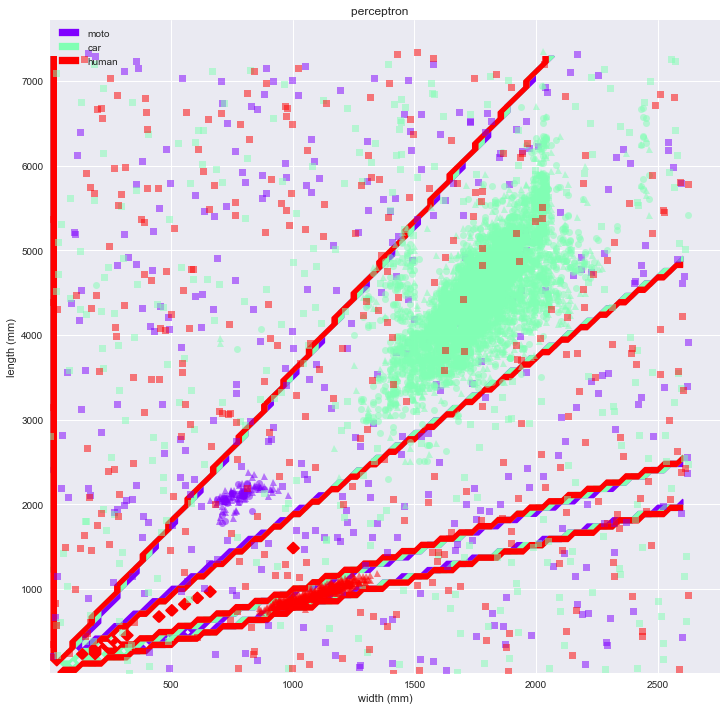

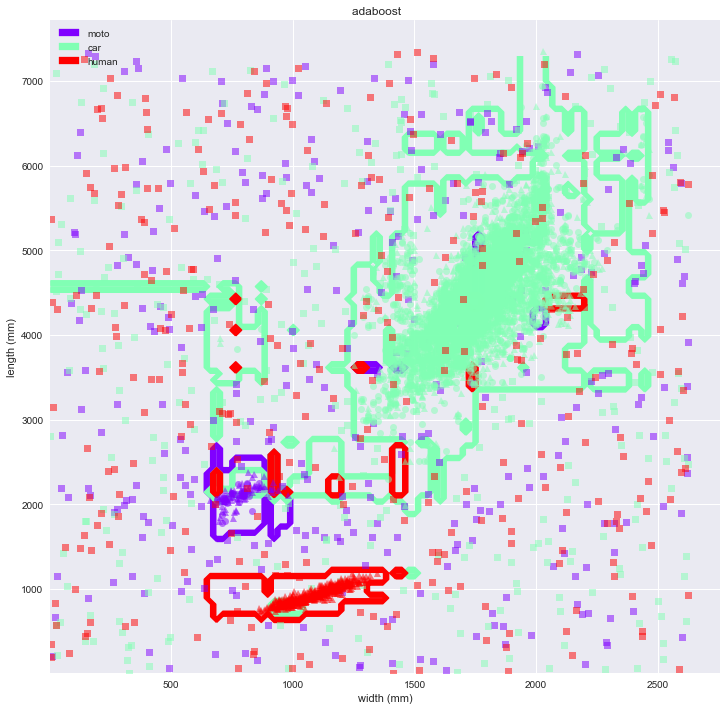

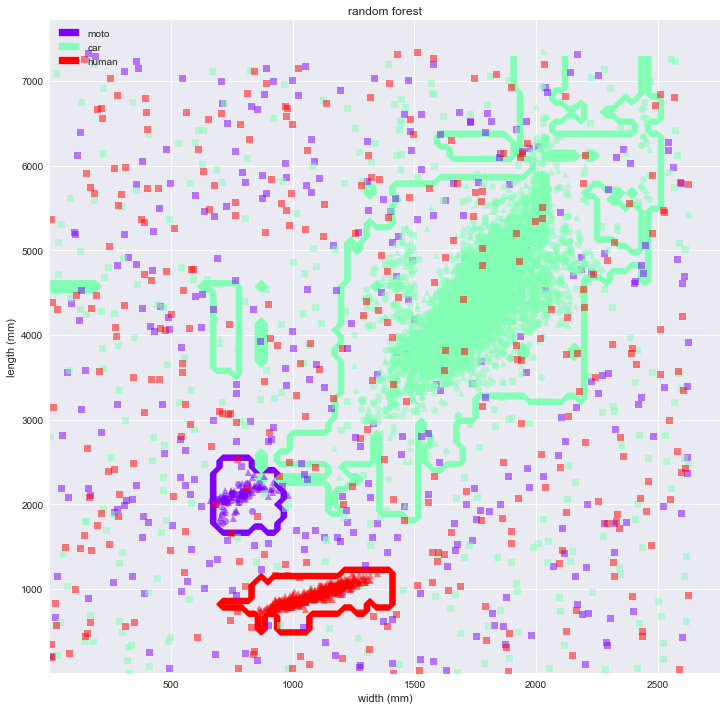

In [9]:
classifiers = [
    neural_network.MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(34,), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
    ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=36, learning_rate=1),
    # svm.SVC(kernel='linear'),
    ensemble.RandomForestClassifier()
]

titles = (
    'perceptron   ',
    'adaboost     ',
    # 'svm          ',
    'random forest'
)

for clf, title in zip(classifiers, titles):
    detector.plot_decision_boundaries(clf, title)


## Parameters tuning

Here we try to optimize the parameters of the classifiers.

Example of usage of the **grid search with cross validation** with the MLP classifier and AdaBoost classifier:

In [10]:
parameters_mlp_test = {
    'learning_rate': ["invscaling"],
    'hidden_layer_sizes': [5, 10],
    'alpha': [.0001, .00001],
    'activation': ["logistic", "relu"]
}

mlp_clf = neural_network.MLPClassifier(max_iter=500)

parameters_adaboost = {
    'n_estimators': [i for i in range(1, 100, 10)],
    'learning_rate': [x * .1 for x in range(1, 10)]
}

ada_clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=4))

print("MLP")
detector.tune_parameters(mlp_clf, parameters_mlp_test)
print("\nAdaBoost")
detector.tune_parameters(ada_clf, parameters_adaboost)
print()  # clean output

MLP
best score: 0.9750300842358605
obtained with parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'learning_rate': 'invscaling'}

AdaBoost
best score: 0.9819494584837545
obtained with parameters: {'learning_rate': 0.6000000000000001, 'n_estimators': 91}

